In [47]:
import torch

import tr_util
import util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from Dimploma.EnvironmentTree import EnvInfo, MatrixEnvInfo, EnvMinimalTreeTwoStep
from Dimploma.ppo_parallel_custom import Agent
from Dimploma.utils.graph_provider import GraphProvider
from Dimploma.utils.my_agent_base import RandomAgent
from Dimploma.utils.testingResult import TestCorrelResult
from zNetwork.my_gcn import GCN
from zNetwork.fully_con import FCN
from zNetwork.hybrid_gcn import HybridNetworkGlobal

In [2]:
%load_ext autoreload
%autoreload 2

In [16]:
# Generate graphs of the given size
node_amount = 100
node_features = 2
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = int(max_edge_amount*0.75)
edge_features = 2
# edge_features = None


main_layers = 3
main_lin_layers = 2
p_layers = 2
v_layers = 2

use_argmax = True

# if GCN
use_catenation = False


In [17]:
graph_provider = GraphProvider(nodes=node_amount, edges=edge_amount)

graph_env = EnvMinimalTreeTwoStep(EnvInfo(graph_provider))
matrix_env = EnvMinimalTreeTwoStep(MatrixEnvInfo(graph_provider, edge_info=True, node_info=True))

In [18]:
# Agents setup
gcn_net = GCN(node_amount, node_features, use_catenation, main_layers, p_layers, v_layers, edge_dim=edge_features)
matrix_net = FCN(node_amount, node_features, edge_amount, main_lin_layers, p_layers, v_layers, True, True)
hybrid_net = HybridNetworkGlobal(node_features, node_amount, edge_dim=edge_features)

gcn_agent = Agent(gcn_net, test=True)
matrix_agent = Agent(matrix_net, test=True)
hybrid_agent = Agent(hybrid_net, test=True)


In [19]:
test_amount = 10
# test_amount = 100
graph_amount = 2
# graph_amount = 10

append = -1
# append = 10


tests = TestCorrelResult(node_amount, test_amount, graph_amount, append=append)

random_uniform = RandomAgent()
tests.addAgent('Random', random_uniform, 'red', multiple_tetst=True)
tests.addAgent('GCN', gcn_agent, 'cyan', multiple_tetst=True)
tests.addAgent('Matrix', matrix_agent, 'magenta', multiple_tetst=True, special=True)
tests.addAgent('Hybrid', hybrid_agent, 'yellow', multiple_tetst=True)


In [20]:
tests.setup('actions')
tests.test(graph_env, matrix_env)

Started tests
Graph 0------------------------------
Started tests for agent Náhodný výber
Finished all tests for agent Náhodný výber
Started tests for agent GCN
Finished all tests for agent GCN
Started tests for agent Matrix
Finished all tests for agent Matrix
Started tests for agent Hybrid
Finished all tests for agent Hybrid
Finished 1 tests for all agents
Graph 1------------------------------
Started tests for agent Náhodný výber
Finished all tests for agent Náhodný výber
Started tests for agent GCN
Finished all tests for agent GCN
Started tests for agent Matrix
Finished all tests for agent Matrix
Started tests for agent Hybrid
Finished all tests for agent Hybrid
Finished 2 tests for all agents
Ended tests


In [24]:
default_path = 'results/correl/test_n100_t10'
default_path

'results/correl/test_n100_t10'

In [26]:
actions_gcn_df = pd.read_csv(f'{default_path}/gcn_actions.csv', index_col=0)
actions_fcn_df = pd.read_csv(f'{default_path}/matrix_actions.csv', index_col=0)
actions_hybrid_df = pd.read_csv(f'{default_path}/hybrid_actions.csv', index_col=0)
actions_random_df = pd.read_csv(f'{default_path}/random_actions.csv', index_col=0)
degrees_df = pd.read_csv(f'{default_path}/degrees.csv', index_col=0)
degrees_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
graph,,,,,,,,,,,,,,,,,,,,,
0,74,76,73,81,70,78,69,73,70,67,...,80,75,71,72,73,82,69,75,78,76
1,79,71,77,79,79,80,76,76,79,72,...,84,75,70,81,81,76,74,76,78,69


In [46]:
torch.tensor(degrees_df.iloc[0].to_numpy()).unique().shape

torch.Size([25])

In [62]:
correlations_gcn = []
for i, row in actions_gcn_df.iterrows():
    corr, _ = pearsonr(degrees_df.iloc[i], row)
    correlations_gcn.append(abs(corr))
correlations_fcn = []
for i, row in actions_fcn_df.iterrows():
    corr, _ = pearsonr(degrees_df.iloc[i], row)
    correlations_fcn.append(abs(corr))
correlations_hybrid = []
for i, row in actions_hybrid_df.iterrows():
    corr, _ = pearsonr(degrees_df.iloc[i], row)
    correlations_hybrid.append(abs(corr))
correlations_random = []
for i, row in actions_random_df.iterrows():
    corr, _ = pearsonr(degrees_df.iloc[i], row)
    correlations_random.append(abs(corr))
correlations = [correlations_gcn, correlations_hybrid, correlations_fcn, correlations_random]
names = [f'Graph{i}' for i in range(len(correlations_gcn))]
names

['Graph0', 'Graph1']

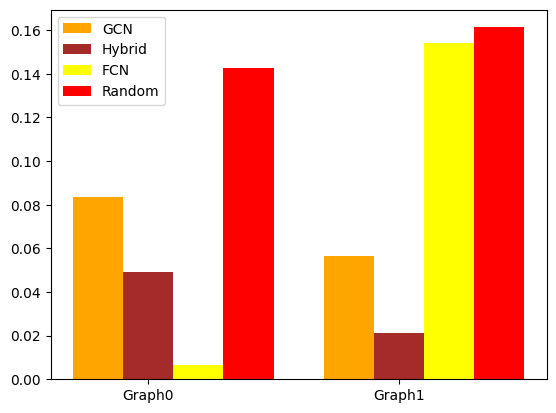

In [63]:
colors = ['orange', 'brown', 'yellow', 'red']
agent_names = ['GCN', 'Hybrid', 'FCN', 'Random']

x = np.arange(len(names))
width = 0.2

for i in range(len(correlations)):
    plt.bar(x + i * width, correlations[i], width=width, label=agent_names[i], color=colors[i])

plt.xticks(x + width, names)
plt.legend()
plt.show()